<strong>License</strong>: BSD<br/>
<strong>Copyright</strong>: Copyright The American Gut Project, 2015

In [1]:
# This cell allows us to render the notebook in the way we wish no matter where
# the notebook is rendered.
from IPython.core.display import HTML
css_file = './ag.css'
HTML(open(css_file, "r").read())

<a id="top"></a>

#Table of Contents
* [Alcohol Use in Healthy Adults](#Alcohol-Use-in-Healthy-Adults)
* [Notebook Requirements](#Notebook-Requirements)
* [Function Import](#Function-Import)
* [Analysis Parameters](#Analysis-Parameters)
	* [Dataset Selection](#Dataset-Selection)
	* [File Saving Parameters](#File-Saving-Parameters)
	* [Text File and Metadata Parameters](#Text-File-and-Metadata-Parameters)
	* [Analysis Category Parameters](#Analysis-Category-Parameters)
	* [Alpha Diversity Parameters](#Alpha-Diversity-Parameters)
	* [Beta Diversity Parameters](#Beta-Diversity-Parameters)
	* [Group Significance Parameters](#Group-Significance-Parameters)
	* [Plotting Parameters](#Plotting-Parameters)
* [Files and Directories](#Files-and-Directories)
	* [Base Directory](#Base-Directory)
	* [Sample Directory and Files](#Sample-Directory-and-Files)
	* [Beta Diversity Directories and Files](#Beta-Diversity-Directories-and-Files)
	* [Group Signifigance Directories and Files](#Group-Signifigance-Directories-and-Files)
	* [Image Directories and Files](#Image-Directories-and-Files)
* [Data Download](#Data-Download)
* [Alpha Diversity](#Alpha-Diversity)
* [Beta Diversity](#Beta-Diversity)
* [Group Significance](#Group-Significance)
	* [Kruskal Wallis OTU Test](#Kruskal-Wallis-OTU-Test)
	* [OTU G Test](#OTU-G-Test)
* [Discussion](#Discussion)
* [References](#References)


# Alcohol Use in Healthy Adults

The role of the gut microbiome has been studied within the context of Alcoholism and Alcoholic Liver Disease (ALD)  [<a id="ref-1"></a>[1](#23326376), <a id="ref-2"></a>[2](#22241860)]. Alcoholism is associated to increased gut permeability, and elevated levels of peripheral endotoxin [<a id="ref-3"></a>reviewed in [3](#22567183)]. Alcoholics with (*n* = 19) and without (*n*  = 22) liver disease showed a significant difference in unweighted UniFrac distance compared to healthy adults (*n* = 10), suggesting changes in community membership [<a id="ref-4"></a>[2](#22241860)]. No significant difference in alpha diversity was observed. The effect of alcohol on the gut microbiome among healthy adults, seperate from alcoholism, has not been examined previously. 

Participants in the American Gut project were asked to self describe the frequency with which they consumed alcohol as:

* Never
* Rarely (a few times/month)
* Occasionally (1-2 times/week)
* Regularly (3-5 days/week)
* Daily

Participants were also free to skip this question. Non-responders are ignored in this analysis. No information was collected about the type of alcohol, volume of alcohol, or alcohol addiction. We believe the prevalence of alcohol dependence is low, even among participants who reported drinking more than three days per week. A study of heavy drinkers (women who consume more than eight or more servings of alcohol per week, or men who consumed fifteen drinks per week) found that only 10% met the criteria for alcohol dependence [<a id="ref-5"></a>[4](#25412029)]. 

This notebook will look at a healthy subset of adults. We defined this as individuals between the age of 20 and 70 who have not used antibiotics in the past year, have a BMI between 18.5 and 30 and who do not report having IBD or diabetes. The rationale behind these criteria are described in the [Preprocessing Notebook](Preprocessing.ipynb).

<a href="#top">Return to the top</a>

# Notebook Requirements

* [Python 2.7](https://www.python.org/download/releases/2.7/)
* [QIIME 1.9](http://www.qiime.org)
* [h5py](http://www.h5py.org) and [hdf5](http://www.hdfgroup.org/HDF5/). These are required to read the American Gut tables.
* [Jinja2](http://jinja.pocoo.org/docs/dev/), [pyzmq](https://learning-0mq-with-pyzmq.readthedocs.org/en/latest/),  [tornado](http://www.tornadoweb.org/en/stable/) and [jsonschema](http://json-schema.org) <br/>These are required to open a local IPython notebook instance. They are not installed automatically when you install IPython as a dependency for QIIME.
* [IPython 3.0](http://ipython.org)
* [Statsmodels 0.6.0](http://statsmodels.sourceforge.net)
* [American Gut Python Library](https://github.com/biocore/American-Gut)
* $\LaTeX$. [LiveTex](http://www.tug.org/texlive/) offers one installation solution.

<a href="#top">Return to the top</a>

# Function Import

We start by importing necessary functions, and determining if files should be overwritten.

In [2]:
import os
import shutil

import scipy
import skbio
import biom
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import americangut.diversity_analysis as div

from matplotlib import rcParams

We will also set up some plotting parameters so the generated figures use Helvetica or Arial as their default font. For more on font properties, see the matplotlib documentation on [text objects](http://matplotlib.org/api/text_api.html?highlight=font#matplotlib.text.Text.set_fontproperties) and [rendering text with LaTex](http://matplotlib.org/users/pgf.html?highlight=font). We will also prompt the IPython notebook to display the images we generate live in the notebook.

In [3]:
# Displays images inline
%matplotlib inline

# Sets up plotting parameters so that the default setting is use to 
# Helvetica in plots
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['text.usetex'] = True

<a href=#top>Return to the top</a>

# Analysis Parameters

We can also set some necessary parameters for handling files and this analysis. It’s easier to set them as a block, here, so that our systems are consistent than to modify each of the variables later in the import if our needs or our data changes.

## Dataset Selection

We're going to work on a single fecal sample donated by healthy adults.

In [4]:
# Selects the body site for data analysis
site = 'fecal'
# Selects the data set being analysed.
dataset = 'sub_participants_one_sample'

<a href="#top">Return to the top</a>

## File Saving Parameters

In [5]:
# Overwrites any files already on the system
overwrite = False
# Saves the image files
save_images = True

<a href="#top">Return to the top</a>

## Text File and Metadata Parameters

In [6]:
# The delimiter; we usually have tab-delimited text files
txt_delim = '\t'
# In QIIME mapping files, the sample ID column in called #SampleID.
map_index = '#SampleID'
# Missing values can be described in a variety of ways.
map_nas = ['NA', 'no_data', 'unknown', '']

<a href="#top">Return to the top</a>

## Analysis Category Parameters

In [7]:
# We want to look at alcohol consumption
category = 'ALCOHOL_FREQUENCY'
# There's an implied order in the frequency of alcohol consumption
c_order = ['Never', 'Rarely (few times/month)', 'Occasionally (1-2 times/week)',
           'Regularly (3-5 times/week)', 'Daily']

<a href="#top">Return to the top</a>

## Alpha Diversity Parameters

In [8]:
# The type of diversity we're using. This should be a column in the mapping file.
a_div_metric = 'PD_whole_tree_mean'
# The plot should have labels to describe what's being shown.
a_ylabel = 'PD Whole Tree Mean'
a_ylim = [5, 55]
a_title = 'Frequency of Alcohol Consumption'
# We will do a post-hoc correction. This sets the method.
a_correct = 'fdr_bh'

<a href="#top">Return to the top</a>

## Beta Diversity Parameters

In [9]:
# We will look at the effect of alcohol on unweighted UniFrac distance
b_div_metric = 'unweighted_unifrac'
# Beta diversity is tested permutatively, both over all and in the post-hoc test.
permanova_n_iter = 999
post_n_iter = 999
# We will use the permutative p-value without correction in the post-hoc test
p_column = 'Nonparametric p-value'
# We want to use all the groups we're examining as reference groups for plotting
b_refs = c_order
# The plot should be colored in varying shades of blue
bc_map = 'YlOrBr'
# The plot should have a title, y axis label, and we can set the y limits.
ubd_ylabel = 'Unweighted UniFrac Distance'
b_ylim = [0.55, 0.95]
b_title = 'Frequency of Alcohol Consumption'

<a href="#top">Return to the top</a>

## Group Significance Parameters

In [10]:
# The colormap used for the abundance (cmap1) and log ratio (cmap2) heatmaps
hm_cmap1 = 'Greens'
hm_cmap2 = 'RdBu_r'

# The limits on the colors shown in the log ratio heatmap. Becuase we're using
# a divering colormap, its best to center this around 0.
hm_clims2 = [-3, 3]

# Sets the size of the labels on each axis
hm_xtick_size = 12
hm_ytick_size = 10

# Limits the groups shown
kw_crit=0.05
gt_crit=0.001

<a href="#top">Return to the top</a>

## Plotting Parameters

In [11]:
# Formats how the x axis labels are displayed on the plots
xtick_angle = 45
xtick_align = 'right'
# Creates a white space border around the saved plots
save_pad = 0.5
save_bbox = 'tight'

<a href="#top">Return to the top</a>

# Files and Directories

We need to import working OUT data for analysis and set up a location where results from our analysis can be saved. This notebook consumes pre-processed tables (OTU tables, mapping files and distance matrices) produced by the [Preprocessing Notebook](Preprocessing.ipynb). It assumes the file structure of the data files corresponds to the file structure used in the preprocessing notebook, and replicates that file structure for other analysis directories.

As we set up directories, we’ll make use the of the **`check_dir`** function. This will create the directories we identify if they do not exist.

## Base Directory

In [12]:
# Sets up the base directory. Ideally, all work is done in this directory
# base_dir = os.path.join(os.path.abspath('.'), 'agp_analysis')
base_dir = os.path.join('/Users/jwdebelius/Desktop/agp_analysis')
div.check_dir(base_dir)

# The directoy where the data has been saved.
working_dir = os.path.join(base_dir, 'sample_data')
div.check_dir(working_dir)

# The directory where files generated during the analysis should be saved.
analysis_dir = os.path.join(base_dir, 'analysis_results')
div.check_dir(analysis_dir)

<a href="#top">Return to the top</a>

## Sample Directory and Files

In [13]:
# Specifies the directory associated with the bodysite
site_dir = os.path.join(working_dir, site)
# The directory for the data set selected
data_dir = os.path.join(site_dir, dataset)

# Sets up file paths for the mapping file, OTU table, and distance matrix
data_otu_fp = os.path.join(data_dir, 'AGP_100nt_even10k_fecal.biom')
data_map_fp = os.path.join(data_dir, 'AGP_100nt_even10k_fecal.txt')
data_ubd_fp = os.path.join(data_dir, '%s_AGP_100nt_even10k_fecal.txt') % b_div_metric

<a href="#top">Return to the top</a>

## Beta Diversity Directories and Files

In [14]:
# The directory where all beta diversity analysis results should be stored
bdiv_dir = os.path.join(analysis_dir, 'beta_diversity')
div.check_dir(bdiv_dir)

# The beta diversity subfolder specific to the body site
bdiv_site_dir = os.path.join(bdiv_dir, site)
div.check_dir(bdiv_site_dir)

# The beta divesity subfolder specific to the data set
bdiv_data_dir = os.path.join(bdiv_site_dir, dataset)
div.check_dir(bdiv_data_dir)

# The folder associated with the specific beta diversity metric
bdiv_data_metric_dir = os.path.join(bdiv_data_dir, b_div_metric)
div.check_dir(bdiv_data_metric_dir)

# The file path for the post hoc beta diversity result
bdiv_post_fp = os.path.join(bdiv_data_metric_dir, '%s_Stats.txt') % category

<a href="#top">Return to the top</a>

## Group Signifigance Directories and Files

In [15]:
# The parent directory for group signifigance
gs_dir = os.path.join(analysis_dir, 'group_signifigance')
div.check_dir(gs_dir)

# The body-site specific directory for group signifigance
gs_site_dir = os.path.join(gs_dir, site)
div.check_dir(gs_site_dir)

# The folder for data set results
gs_data_dir = os.path.join(gs_site_dir, dataset)
div.check_dir(gs_data_dir)

# Group signifigance can be performed on multiple levels; we want to focus on the OTU table
gs_data_otu_dir = os.path.join(gs_data_dir, 'otus')
div.check_dir(gs_data_otu_dir)

# Supplies the file names for the group signifigance test files that will be generated.
kruskal_fp = os.path.join(gs_data_otu_dir, '%s_kw.txt') % category
gtest_fp = os.path.join(gs_data_otu_dir, '%s_gt.txt') % category

<a href="#top">Return to the top</a>

## Image Directories and Files

In [16]:
# Creates a parent directory for the images from analysis
image_dir = os.path.join(analysis_dir, 'images')
div.check_dir(image_dir)

# Creates a directory focused on the the body site
site_image_dir = os.path.join(image_dir, site)
div.check_dir(site_image_dir)

# Creates a image directory focused on the data set
data_image_dir = os.path.join(site_image_dir, dataset)
div.check_dir(data_image_dir)

# Sets up the file name for images generated by analysis. String replacement is done by 
# a dictionary.
image_pattern = os.path.join(data_image_dir, '%(div_metric)s_%(image_type)s_%(category)s.png')

<a href="#top">Return to the top</a>

# Data Download

We will start our analysis using the clean, rarefied tables generated by the Preprocessing Notebook. If necessary, these files can be downloaded. The necessary files are then loaded into the notebook for analysis and processing.

In [17]:
# Gets data for single samples with all the OTUs
if not os.path.exists(site_dir) or overwrite:
    # Downloads the files
    !curl -OL ftp://ftp.microbio.me/pub/American-Gut-precomputed/r1-15/fecal.tgz
    # Extracts the data
    !tar -xzf fecal.tgz
    # Moves the data
    os.remove(os.path.join('.', 'fecal.tgz'))
    shutil.move(os.path.join('.', 'fecal'), working_dir)

In [18]:
# Loads the files into the notebook
data_otu = biom.load_table(data_otu_fp)
data_map = pd.read_csv(data_map_fp,
                       sep=txt_delim, 
                       na_values=map_nas,
                       index_col=False)
data_map.index = data_map[map_index]
del data_map[map_index]
data_ubd = skbio.DistanceMatrix.read(data_ubd_fp)

<a href="#top">Return to the top</a>

# Alpha Diversity

[Alpha Diversity](http://en.wikipedia.org/wiki/Alpha_diversity) was calculated as the mean of ten rarefactions in the [Preprocessing Notebook](http://localhost:8888/notebooks/Preprocessing.ipynb#Whole-Table-Alpha-Diversity). We will focus on PD Whole Tree Diversity, an unweighted phylogenetic metric [<a id="ref-6"></a>[5](#15831718)]. The alpha diversity will be represented as [box plots](http://en.wikipedia.org/wiki/Box_plot). We will test for signifigant differences between groups using a [kruskal-wallis test](http://en.wikipedia.org/wiki/Kruskal–Wallis_one-way_analysis_of_variance), since we cannot assume normality. Pairwise post-hoc comparisons will also be tested using a kruskal-wallis test, with multiple hypothesis correction. 
The parameters for alpha diversity can be set <a href="#Alpha-Diversity-Parameters">above</a>.

,Counts,Mean,Median,Stdv,Never,Rarely (few times/month),Occasionally (1-2 times/week),Regularly (3-5 times/week)
ALCOHOL_FREQUENCY,,,,,,,,
Never,157,30.295906,30.675563,6.169283,NaN,NaN,NaN,NaN
Rarely (few times/month),229,31.740524,31.948301,5.658872,0.034713,NaN,NaN,NaN
Occasionally (1-2 times/week),223,32.103996,31.971235,5.085926,0.005849,0.585461,NaN,NaN
Regularly (3-5 times/week),210,31.678711,31.396285,5.465161,0.045326,0.836524,0.530734,NaN
Daily,135,32.465079,32.332911,5.030633,0.005849,0.378350,0.585461,0.335636


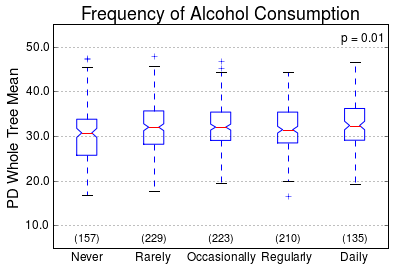

In [19]:
# Renders the boxplot
alpha_ax = div.pretty_pandas_boxplot(meta=data_map,
                                     group=category, 
                                     order=c_order,
                                     cat=a_div_metric,
                                     ylabel=a_ylabel,
                                     ylim=a_ylim,
                                     title=a_title)
if save_images:
    alpha_fig = alpha_ax.figure
    alpha_fig.savefig(image_pattern % {'div_metric': a_div_metric, 
                                       'image_type': 'boxplot', 
                                       'category': category.lower()},
                      pad_inches=save_pad,
                      bbox_inches=save_bbox)

# Displays the post-hoc table
alpha_post = div.post_hoc_pandas(meta=data_map,
                                 group=category, 
                                 order=c_order,
                                 cat=a_div_metric,
                                 correct=a_correct)
alpha_post


<a href="#top">Return to the top</a>

# Beta Diversity

[Beta diversity](http://en.wikipedia.org/wiki/Beta_diversity) will be quantified using unweighted UniFrac distance [<a id="ref-7"></a>[6](#16332807)]. We will use permutative testing to look for differences between the groups, using a post-hoc test implemented through QIIME's [`make_distance_boxplots.py`](http://qiime.org/scripts/make_distance_boxplots.html) script. We will use the permuative p value without multiple hypothesis correction as some consider permutation a solution to the multiple hypothesis problem [<a id="ref-8"></a>[7](#18939983)].

The parameters for the bar charts, like the coloring and text size, can be set <a href="#Beta-Diversity-Parameters">above</a>.

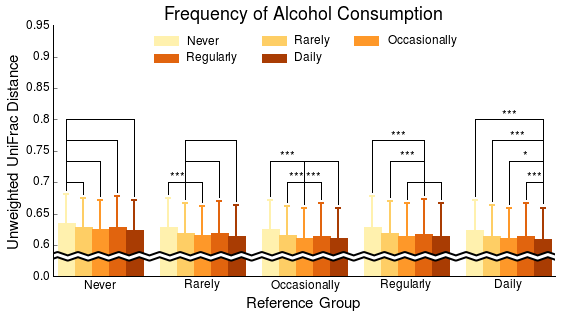

In [20]:
# Performs post-hoc analysis comparing categories
if not os.path.exists(bdiv_post_fp) or overwrite:
    !make_distance_boxplots.py -d $data_ubd_fp -m $data_map_fp -f $category -o $bdiv_data_metric_dir --suppress_all_between --suppress_all_within -n $post_n_iter

# Loads the post-hoc table for category
post_hoc_ubd = pd.read_csv(bdiv_post_fp,
                           sep=txt_delim,
                           skiprows=7)
# Plots the unweighted UniFrac
beta_ax = div.beta_diversity_bars(data_ubd, data_map, category, 
                                  order=c_order, 
                                  num_iter=permanova_n_iter,
                                  p_table=post_hoc_ubd,
                                  p_tab_col=p_column,
                                  ylim=b_ylim,
                                  colormap=bc_map,
                                  ylabel=ubd_ylabel,
                                  title=b_title)
beta_fig = beta_ax.get_figure()
beta_fig.set_size_inches(9, 4.5)

if save_images:
    beta_fig.savefig(image_pattern % {'div_metric': b_div_metric, 
                                      'image_type': 'barchart', 
                                       'category': category.lower()},
                      pad_inches=save_pad,
                      bbox_inches=save_bbox)

The bar charts are read as the distance between the reference group and the group in the bar color. So, the very first bar in chart in the first reference group (labeled "Never") is the within-group distance for samples from healthy individuals who never drink alcohol (pale yellow). The next bar (colored yellow) is the between group distance for people who never drink alcohol compared to those who rarely drink alcohol. We the within-group distance is larger for non drinkers than for people who occasionally drink.

Significance is shown in the lines over the bars. An unlabeled line means that the inter-group distance is not significantly larger than the intra-group distance for that pair. Significance is coded using the following symbols:

<table>
    <tr style="border-left:hidden;
               border-right:hidden;
               border-collapse:collapse;
               width:200px;
               text-align:center">
       <th style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  width:100px;
                  text-align:center">
           Max $p$
       </th>
       <th style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  width:100px;
                  text-align:center">
           Symbol
       </th>
    </tr>
    <tr style="border-left:hidden;
               border-right:hidden;
               border-collapse:collapse;
               border-bottom:hidden;
               text-align:center">
        <td style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  text-align:center">
            0.1
        </td>
        <td style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  text-align:center">
          <code>+</code>
        </td>
    </tr>
    <tr style="border-left:hidden;
               border-right:hidden;
               border-collapse:collapse;
               border-bottom:hidden;
               text-align:center">
        <td style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  text-align:center">
            0.5
        </td>
        <td style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  text-align:center">
          <code>\*</code>
        </td>
    </tr>
    <tr style="border-left:hidden;
               border-right:hidden;
               border-collapse:collapse;
               border-bottom:hidden;
               text-align:center">
        <td style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  text-align:center">
            0.01
        </td>
        <td style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  text-align:center">
          <code>\*\*</code>
        </td>
    </tr>
    <tr style="border-left:hidden;
               border-right:hidden;
               border-collapse:collapse;
               border-bottom:hidden;
               text-align:center">
        <td style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  text-align:center">
            0.001
        </td>
        <td style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  text-align:center">
          <code>\*\*\*</code>
        </td>
    </tr>
    <tr style="border-left:hidden;
               border-right:hidden;
               border-collapse:collapse;
               text-align:center">
        <td style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  text-align:center">
            0.0001
        </td>
        <td style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  text-align:center">
          <code>\*\*\*\*</code>
        </td>
    </tr>
</table>

Because we used a permutative test, remember the minimum p value can be no smaller than $\frac{1}{1 + n_{permutations}}$.

<a href="#top">Return to the top</a>

# Group Significance

While alpha diversity and beta diversity give us ideas about the structure of the communities, we can look for individual bacterial taxa which differ using individual tests. We use a [kruskal-wallis](http://en.wikipedia.org/wiki/Kruskal–Wallis_one-way_analysis_of_variance) test can be used to compare the abundances of different bacteria, since bacterial abundances are not normally distributed [<a id="ref-9"></a>[8](#23284876)]. The results of this test parallel the results seen using weighted diversity metrics.

There is also a trend in microbiome that that compositional analysis, looking at the presence and absence of taxa, rather than their abundance. One approach to the presence, absence measurement is the [G test](http://en.wikipedia.org/wiki/G-test) or log-likelihood test. This test is closer to an unweighted diversity metric.

## Kruskal Wallis OTU Test

We will start by generating the significance files, and then plot our Kruskal Wallis results as a heat map.

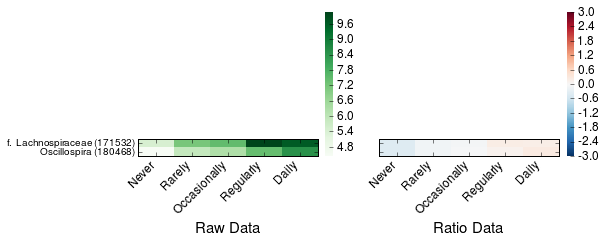

In [21]:
# Sets up the order of the groups for testing
h_order = ['%s_mean' %s for s in c_order]

# Performs the appropriate tests
if not os.path.exists(kruskal_fp) or overwrite:
    !group_significance.py -i $data_otu_fp -m $data_map_fp -c $category -o $kruskal_fp -s kruskal_wallis
if not os.path.exists(gtest_fp) or overwrite:
    !group_significance.py -i $data_otu_fp -m $data_map_fp -c $category -o $gtest_fp -s g_test

# Plots the kruskal wallis heatmap
if os.path.exists(kruskal_fp):
    kw_table = pd.read_csv(kruskal_fp, sep=txt_delim)
    [data_hm1_kw_ax, data_hm2_kw_ax], kw_feats = \
        div.make_dual_heatmaps(kw_table, 
                               h_order, 
                               cmap1=hm_cmap1, 
                               cmap2=hm_cmap2, 
                               clims2=hm_clims2, 
                               xtick_size=hm_xtick_size, 
                               ytick_size=hm_ytick_size,
                               p_crit=kw_crit,
                               xfont_angle=xtick_angle,
                               xfont_align=xtick_align)
    if save_images:
        kw_fig = data_hm1_kw_ax.figure
        kw_fig.savefig(image_pattern % {'div_metric': 'otu_kruskal', 
                                        'image_type': 'heatmap', 
                                        'category':category.lower()},
                       pad_inches=save_pad,
                       bbox_inches=save_bbox)

<a href="#top">Return to the top</a>

## OTU G Test

We can also look at the presence or absence of OTUs using a G-test.

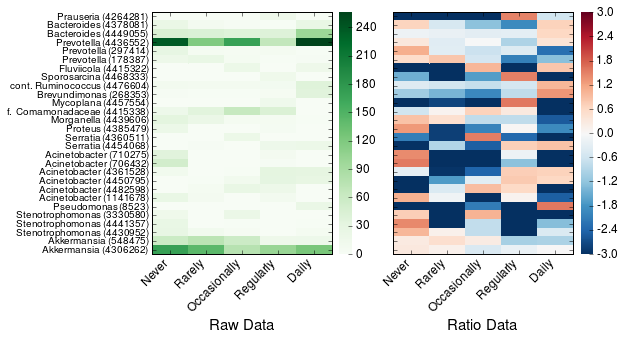

In [22]:
if os.path.exists(gtest_fp):
    gt_table = pd.read_csv(gtest_fp, sep=txt_delim)
    [data_hm1_gt_ax, data_cat_hm2_gt_ax], data_cat_gt_feats = \
        div.make_dual_heatmaps(gt_table, 
                               h_order, 
                               cmap1=hm_cmap1, 
                               cmap2=hm_cmap2, 
                               clims2=hm_clims2, 
                               xtick_size=hm_xtick_size, 
                               ytick_size=hm_ytick_size,
                               p_crit=gt_crit,
                               xfont_angle=xtick_angle,
                               xfont_align=xtick_align)
    if save_images:
        gt_fig = data_hm1_gt_ax.figure
        gt_fig.savefig(image_pattern % {'div_metric': 'otu_gtest', 
                                        'image_type': 'heatmap', 
                                        'category':category.lower()},
                       pad_inches=save_pad,
                       bbox_inches=save_bbox)

<a href="#top">Return to the top</a>

# Discussion

We see a trend of generally increasing alpha diversity among drinkers. There is a significant difference in diversity associated with any alcohol consumption, although daily drinkers have the greatest increase in alpha diversity compared to non-drinkers.

Non drinkers have the most heterogenous microbiome: the average intra-group UniFrac distance is  greater than the between-group distances. However, when compared to any frequency of alcohol consumption, people who do not drink were less like the drinkers than those who consumed alcohol. Furthermore, there’s a trend where in comparison to rare drinkers (people who drink less than once a week), have significantly different communities than those who drink more than three times a week.

Alcohol consumption is correlated with an increase in an OTU mapped to family Lachnospiraceae and Oscillospira, two members of Class Clostridiales. Non drinkers are more likely to have OTUs mapped to genus *Prevotella*, genus *Stenotrophomonas*, and genus *Akkermansia* than people who consumed alcohol. Alcohol consumption was associated with a higher probability of genus *Serratia*, a member of class Gammaproteobacteria.
This analysis suggests that alcohol consumption is associated with changes in the gut microbiome of healthy adults. Moving forward, intervention studies, looking at the effect of adding or altering alcohol consumption may expand knowledge of the effect.

<a href="#top">Return to the top</a>

# References

1. <a id="23326376"></a>[^](#ref-1)Bull-Otterson, L.; Feng, W.; Kirpich, I.; Wang, Y.; Liu, Y.; Gobjishvili, L.; Joshi-Barve, S.; Ayvaz, T.; Petrosino, J.; Kong, M.; Barker, D.; McClain, C.; and Barve, S. (2013). "[Metagenomic analysis of alcohol induced pathogenic alterations in the intestinal microbiome and the effect of *Lactobacillus rhamnosus* GG treatment](http://www.ncbi.nlm.nih.gov/pubmed/23326376)." *PLoS One.* **8**:e53028.

2. <a id="22241860"></a>[^](#ref-2) [^](#ref-4)Mutlu, E.A.; Gillevet, P.M.; Rangwala, H.; Sikaroodi, M.; Naqvi, A.; Engen, P.A.; Kwasny, M.; Lau, C.K.; and Keshavarzian, A. (2012). "[Colonic microbiome is altered in alcoholism](http://www.ncbi.nlm.nih.gov/pubmed/22241860)." *Am J Physiol Gastrointest Liver Physiol*. **302**: G966-G978.

3. <a id="22567183"></a>[^](#ref-3)Yan, A.W. and Schnabl, B. (2012) "[Bacterial translocation and changes in the intestinal microbiome associated with alcoholic liver disease](http://www.ncbi.nlm.nih.gov/pubmed/22567183)." *World J Hepatol*. **4**: 110 -118.

4. <a id="25412029"></a>[^](#ref-5)Esser, M.B.; Hedden, S.L.; Kanny, D.; Brewer, R.D.; Gfroerer, J.C.; Naimi, T.S. (2014). "[Prevalence of alcohol dependence among US adult drinkers, 2009-2011](http://www.ncbi.nlm.nih.gov/pubmed/25412029)." *Prev Chronic Disease*. **11**: E206.

5. <a id="15831718"></a>[^](#ref-6)Eckburg, P.B.; Bik, E.M.; Bernstein C.N.; Purdom, E.; Dethlefson, L.; Sargent, M.; Gill, S.R.; Nelson, K.E.; Relman, D.A. (2005) “[Diversity of the human intestinal microbial flora](http://www.ncbi.nlm.nih.gov/pubmed/15831718).”   *Science*. **308**: 1635-1638.

6. <a id="16332807"></a>[^](#ref-7)Lozupone, C.; and Knight, R. (2005). “[UniFrac: a new phylogenetic method for comparing microbial communities](http://www.ncbi.nlm.nih.gov/pubmed/16332807).” *Appl Enviro Microbiol*. **71**: 8228-8235.  

7. <a id="18939983"></a>[^](#ref-8)Camargo, A.; Azuaje, F.; Wang, H.; and Zheng, H. (2008) “[Permutation-based statistical tests for multiple hypotheses](http://www.ncbi.nlm.nih.gov/pubmed/18939983).” *Source Code Biol Med*. **21**:15.   

8. <a id="23284876"></a>[^](#ref-9)La Rosa, P.S.; Brooks, J.P.; Deych, E.; Boone, E.L.; Edwards, D.J.; Wang, Q.; Sodergren, E.; Weinstock, G.; Shannon, W.D. (2012) “[Hypothesis testing and power calculations for taxonomic-based human microbiome data](http://www.ncbi.nlm.nih.gov/pubmed/23284876).” *PloS One*. **7**:e52078.  

<a href="#top">Return to the top</a>